In [1]:
import tensorflow as tf
import os
import numpy as np
import random
SEED = 0
#------------------------------------------------------------------------------------
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
#------------------------------------------------------------------------------------
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)
#-----------------------------------------------------------------------------------

In [2]:
%matplotlib notebook
import pandas as pd
from data_extraction import *
from resp_signal_extraction import *
from rr_extration import *
from sklearn.preprocessing import MinMaxScaler
import re
import pickle as pkl
from tf_model import *
from tf_model_new import *
from tf_model_evi import *
from tf_model_attn_monte import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt
from filters import *
import tqdm
import plotly as py
import plotly.figure_factory as ff
import ipywidgets as widgets
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.offline.init_notebook_mode(connected = True)
from plotly import tools
import plotly.express as px

In [3]:
input_conf = 'conff'

In [4]:
with open('output','rb') as f:
    output_data = pkl.load(f)

with open('input','rb') as f:
    input_data = pkl.load(f)

with open('raw_signal.pkl','rb') as f:
    raw_data = pkl.load(f)

input_data = np.transpose(input_data, (0,2,1))
raw_data = np.transpose(raw_data, (0,2,1))
annotation = pd.read_pickle('/media/acrophase/pose1/charan/BR_Uncertainty/MONTE_CARLO/annotation.pkl')
reference_rr = (annotation['Reference_RR'].values).reshape(-1,1)

input_data = np.around(input_data , decimals = 4)
raw_data = np.around(raw_data , decimals = 4)
output_data = np.around(output_data , decimals = 4)
reference_rr = np.around(reference_rr , decimals = 4)

tensor_input = tf.convert_to_tensor(input_data, dtype = 'float32')
tensor_output = tf.convert_to_tensor(output_data, dtype = 'float32')
tensor_ref_rr = tf.convert_to_tensor(reference_rr, dtype = 'float32')
tensor_raw_data = tf.convert_to_tensor(raw_data, dtype = 'float32')
training_ids = annotation['patient_id'] < 13

x_train_data = tensor_input[tf.convert_to_tensor(training_ids.values)]
x_test_data = tensor_input[tf.convert_to_tensor(~(training_ids.values))]
x_train_ref_rr = tensor_ref_rr[tf.convert_to_tensor(training_ids.values)]
x_test_ref_rr = tensor_ref_rr[tf.convert_to_tensor(~(training_ids.values))]
x_train_raw_sig = tensor_raw_data[tf.convert_to_tensor(training_ids.values)]
x_test_raw_sig = tensor_raw_data[tf.convert_to_tensor(~(training_ids.values))]

y_train_data = tensor_output[tf.convert_to_tensor(training_ids.values)]
y_test_data = tensor_output[tf.convert_to_tensor(~(training_ids.values))]

2021-11-20 09:07:03.422881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 09:07:03.428183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 09:07:03.428811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 09:07:03.450155: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
if input_conf == 'confc':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , y_train_data))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , y_test_data))
        test_dataset = test_dataset.batch(128)

if input_conf == 'confb':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , x_test_ref_rr))
        test_dataset = test_dataset.batch(128)

if input_conf == 'confd':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , y_train_data, x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , y_test_data, x_test_ref_rr))
        test_dataset = test_dataset.batch(128)
if input_conf == 'confa':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_raw_sig)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , x_test_ref_rr))
        test_dataset = test_dataset.batch(128)

if input_conf == 'confe':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , y_train_data))
        train_dataset = train_dataset.shuffle(len(x_train_raw_sig)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , y_test_data))
        test_dataset = test_dataset.batch(128)
if input_conf == 'conff':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , y_train_data, x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , y_test_data, x_test_ref_rr))
        test_dataset = test_dataset.batch(128)

In [6]:
if input_conf == 'confc':
    model_input_shape = (128,3)
    model  = BRUnet(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_WO_ATT/confc/best_model_0.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step , (x_batch_test,y_batch_test) in enumerate(test_dataset):
        output = model(x_batch_test)
        test_loss = loss_fn(y_batch_test , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
        
#-----------------------------------------------------------------------------------------------------------------
if input_conf == 'confd':
    model_input_shape = (128,3)
    model  = BRUnet_Multi_resp(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_WO_ATT/confd/best_model_40.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        test_output,test_out_rr = model(x_batch_test)
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
        test_loss_list.append(test_loss)
            
#------------------------------------------------------------------------------------------------------------------
if input_conf == 'confb':
    model_input_shape = (128,3)
    model  = BRUnet_Encoder(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_WO_ATT/confb/best_model_10.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step , (x_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        output = model(x_batch_test)
        test_loss = loss_fn(x_batch_test_ref_rr , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
#--------------------------------------------------------------------------------------------------------------------
if input_conf == 'confe':
    model_input_shape = (2048,3)
    model  = BRUnet_raw(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_WO_ATT/confe/best_model_20.001_0.0001_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step , (x_batch_test_raw,y_batch_test) in enumerate(test_dataset):
        output = model(x_batch_test_raw)
        test_loss = loss_fn(y_batch_test , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
        
#-------------------------------------------------------------------------------------------------------------------
if input_conf == 'confa':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_encoder(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_WO_ATT/confa/best_model_10.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step , (x_batch_test_raw, x_batch_test_ref_rr) in enumerate(test_dataset):
        output = model(x_batch_test_raw)
        test_loss = loss_fn(x_batch_test_ref_rr , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
#-------------------------------------------------------------------------------------------------------------------
if input_conf == 'conff':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_multi(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_WO_ATT/conff/best_model_10.0001_0.0001_100.h5')        
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    for step , (x_batch_test_raw , y_batch_test , x_batch_test_ref_rr) in enumerate(test_dataset):
        test_output,test_out_rr = model(x_batch_test_raw)
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
        test_loss_list.append(test_loss)

2021-11-20 09:07:04.757399: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202


In [7]:
def extremas_extraction(signal):
    avg_breath_duration = np.array([])
    extrema_relevent = []
    for item in signal:
        amplitude = np.array([])
        pos_peaks , _ = scipy.signal.find_peaks(item , height = [-3000,3000])
        neg_peaks , _ = scipy.signal.find_peaks(-1*item , height = [-3000 , 3000])
        extremas = np.concatenate((pos_peaks , neg_peaks))
        extremas = np.sort(extremas)
        for i in range(len(extremas)):
            amplitude = np.append(amplitude , item[int(extremas[i])])
        amplitude_diff = np.abs(np.diff(amplitude))
        q3 = np.percentile(amplitude_diff , 75)
        threshold = 0.3*q3
        eliminate_pairs_of_extrema = 1
        while(eliminate_pairs_of_extrema):
            amps = np.array([])
            if len(extremas)<3:
                eliminate_pairs_of_extrema = 0
                continue
            for i in range(len(extremas)):
                amps = np.append(amps , item[int(extremas[i])])
            amp_diff = np.abs(np.diff(amps)) 
            min_amp_diff , index = min(amp_diff) , np.argmin(amp_diff)
            #print(min_amp_diff)
            if min_amp_diff > threshold:
                eliminate_pairs_of_extrema = 0
                #extrema_relevent = extremas
            else:
                extremas = np.concatenate((extremas[0:index] , extremas[index+2 :]))
                #amplitude_diff = np.delete(amplitude_diff , index)
        if item[int(extremas[0])] < item[int(extremas[1])]:
            extremas = extremas[1:]
        if item[int(extremas[-1])] < item[int(extremas[-2])]:
            extremas = extremas[:-1]
        no_of_breaths = (len(extremas)-1)/2
        breath_duration = extremas[-1] - extremas[0]
        avg_breath_duration = np.append(avg_breath_duration , breath_duration/no_of_breaths)
        extrema_relevent.append(extremas)
    return avg_breath_duration , extrema_relevent

In [8]:
ref_sig = y_test_data.numpy()
fbpB , fbpA = band_pass(0.1,0.7,8)
final_ref_resp_sig = []
for item in ref_sig:
    final_ref_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
final_ref_resp_sig = np.array(final_ref_resp_sig)

In [9]:
if input_conf == 'confa':
    final_output_rr = final_output.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
#----------------------------------------------------------------------------------------------------------------   
if input_conf == 'confb':
    final_output_rr = final_output.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))

In [10]:
if input_conf == 'confc':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    

    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#--------------------------------------------------------------------------------------------------------------------    
if input_conf == 'confe':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    final_output_resp = final_output.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

In [11]:
if input_conf == 'confd':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#-------------------------------------------------------------------------------------------------------
if input_conf == 'conff':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

Mean Absolute Error average wise for conff is: 2.439303813320187
Root Mean Square Error average wise for conff is: 3.038453636269699
Mean Absolute Error instantaneous wise for conff is: 3.562626680903347
Root Mean Square Error instantaneous wise for conff is: 4.456110213561211


# WITH ATTENTION BLOCK

In [12]:
if input_conf == 'confc':
    model_input_shape = (128,3)
    model  = BRUnet_ATT(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODELS_WITH_ATT/confc/best_model_10.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    attn1 = tf.convert_to_tensor([])
    attn2 = tf.convert_to_tensor([])
    attn3 = tf.convert_to_tensor([])
    attn4 = tf.convert_to_tensor([])
    attn5 = tf.convert_to_tensor([])
    for step , (x_batch_test,y_batch_test) in enumerate(test_dataset):
        output,at_1,at_2,at_3,at_4,at_5 = model(x_batch_test)
        test_loss = loss_fn(y_batch_test , output)
        if step == 0:
            final_output = output
            attn1 = at_1
            attn2 = at_2
            attn3 = at_3
            attn4 = at_4
            attn5 = at_5
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
            attn1 = tf.concat([attn1 , at_1] , axis = 0)
            attn2 = tf.concat([attn2 , at_2] , axis = 0)
            attn3 = tf.concat([attn3 , at_3] , axis = 0)
            attn4 = tf.concat([attn4 , at_4] , axis = 0)
            attn5 = tf.concat([attn5 , at_5] , axis = 0)
        test_loss_list.append(test_loss)
        
#-----------------------------------------------------------------------------------------------------------------
if input_conf == 'confd':
    model_input_shape = (128,3)
    model  = BRUnet_Multi_resp_ATT(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODELS_WITH_ATT/confd/best_model_0.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    attn1 = tf.convert_to_tensor([])
    attn2 = tf.convert_to_tensor([])
    attn3 = tf.convert_to_tensor([])
    attn4 = tf.convert_to_tensor([])
    attn5 = tf.convert_to_tensor([])
    attn6 = tf.convert_to_tensor([])
    attn7 = tf.convert_to_tensor([])
    attn8 = tf.convert_to_tensor([])
    attn9 = tf.convert_to_tensor([])
    for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        test_output,test_out_rr,at_1,at_2,at_3,at_4,at_5,at_6,at_7,at_8,at_9 = model(x_batch_test)
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
            attn1 = at_1
            attn2 = at_2
            attn3 = at_3
            attn4 = at_4
            attn5 = at_5
            attn6 = at_6
            attn7 = at_7
            attn8 = at_8
            attn9 = at_9
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
            attn1 = tf.concat([attn1 , at_1] , axis = 0)
            attn2 = tf.concat([attn2 , at_2] , axis = 0)
            attn3 = tf.concat([attn3 , at_3] , axis = 0)
            attn4 = tf.concat([attn4 , at_4] , axis = 0)
            attn5 = tf.concat([attn5 , at_5] , axis = 0)
            attn6 = tf.concat([attn6 , at_6] , axis = 0)
            attn7 = tf.concat([attn7 , at_7] , axis = 0)
            attn8 = tf.concat([attn8 , at_8] , axis = 0)
            attn9 = tf.concat([attn9 , at_9] , axis = 0)
        test_loss_list.append(test_loss)
            
#------------------------------------------------------------------------------------------------------------------
if input_conf == 'confb':
    model_input_shape = (128,3)
    model  = BRUnet_Encoder_ATT(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODELS_WITH_ATT/confb/best_model_0.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    attn1 = tf.convert_to_tensor([])
    attn2 = tf.convert_to_tensor([])
    attn3 = tf.convert_to_tensor([])
    attn4 = tf.convert_to_tensor([])
    for step , (x_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        output,at_1,at_2,at_3,at_4 = model(x_batch_test)
        test_loss = loss_fn(x_batch_test_ref_rr , output)
        if step == 0:
            final_output = output
            attn1 = at_1
            attn2 = at_2
            attn3 = at_3
            attn4 = at_4
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
            attn1 = tf.concat([attn1 , at_1] , axis = 0)
            attn2 = tf.concat([attn2 , at_2] , axis = 0)
            attn3 = tf.concat([attn3 , at_3] , axis = 0)
            attn4 = tf.concat([attn4 , at_4] , axis = 0)
        test_loss_list.append(test_loss)
#--------------------------------------------------------------------------------------------------------------------
if input_conf == 'confe':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_ATT(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODELS_WITH_ATT/confe/best_model_10.001_0.0001_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    attn1 = tf.convert_to_tensor([])
    attn2 = tf.convert_to_tensor([])
    attn3 = tf.convert_to_tensor([])
    attn4 = tf.convert_to_tensor([])
    attn5 = tf.convert_to_tensor([])
    attn6 = tf.convert_to_tensor([])
    attn7 = tf.convert_to_tensor([])
    for step , (x_batch_test_raw,y_batch_test) in enumerate(test_dataset):
        output,at_1,at_2,at_3,at_4,at_5,at_6,at_7 = model(x_batch_test_raw)
        test_loss = loss_fn(y_batch_test , output)
        if step == 0:
            final_output = output
            attn1 = at_1
            attn2 = at_2
            attn3 = at_3
            attn4 = at_4
            attn5 = at_5
            attn6 = at_6
            attn7 = at_7
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
            attn1 = tf.concat([attn1 , at_1] , axis = 0)
            attn2 = tf.concat([attn2 , at_2] , axis = 0)
            attn3 = tf.concat([attn3 , at_3] , axis = 0)
            attn4 = tf.concat([attn4 , at_4] , axis = 0)
            attn5 = tf.concat([attn5 , at_5] , axis = 0)
            attn6 = tf.concat([attn6 , at_6] , axis = 0)
            attn7 = tf.concat([attn7 , at_7] , axis = 0)
        test_loss_list.append(test_loss)
        
#-------------------------------------------------------------------------------------------------------------------
if input_conf == 'confa':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_encoder_ATT(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODELS_WITH_ATT/confa/best_model_10.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    attn1 = tf.convert_to_tensor([])
    attn2 = tf.convert_to_tensor([])
    attn3 = tf.convert_to_tensor([])
    attn4 = tf.convert_to_tensor([])
    for step , (x_batch_test_raw, x_batch_test_ref_rr) in enumerate(test_dataset):
        output,at_1,at_2,at_3,at_4  = model(x_batch_test_raw)
        test_loss = loss_fn(x_batch_test_ref_rr , output)
        if step == 0:
            final_output = output
            attn1 = at_1
            attn2 = at_2
            attn3 = at_3
            attn4 = at_4
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
            attn1 = tf.concat([attn1 , at_1] , axis = 0)
            attn2 = tf.concat([attn2 , at_2] , axis = 0)
            attn3 = tf.concat([attn3 , at_3] , axis = 0)
            attn4 = tf.concat([attn4 , at_4] , axis = 0)
        test_loss_list.append(test_loss)
#-------------------------------------------------------------------------------------------------------------------
if input_conf == 'conff':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_multi_ATT(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODELS_WITH_ATT/conff/best_model_10.0001_0.0001_100.h5')        
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    attn1 = tf.convert_to_tensor([])
    attn2 = tf.convert_to_tensor([])
    attn3 = tf.convert_to_tensor([])
    attn4 = tf.convert_to_tensor([])
    attn5 = tf.convert_to_tensor([])
    attn6 = tf.convert_to_tensor([])
    attn7 = tf.convert_to_tensor([])
    attn8 = tf.convert_to_tensor([])
    attn9 = tf.convert_to_tensor([])
    attn10 = tf.convert_to_tensor([])
    attn11 = tf.convert_to_tensor([])
    for step , (x_batch_test_raw , y_batch_test , x_batch_test_ref_rr) in enumerate(test_dataset):
        test_output,test_out_rr,at_1,at_2,at_3,at_4,at_5,at_6,at_7,at_8,at_9,at_10,at_11 = model(x_batch_test_raw)
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
            attn1 = at_1
            attn2 = at_2
            attn3 = at_3
            attn4 = at_4
            attn5 = at_5
            attn6 = at_6
            attn7 = at_7
            attn8 = at_8
            attn9 = at_9
            attn10 = at_10
            attn11 = at_11
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
            attn1 = tf.concat([attn1 , at_1] , axis = 0)
            attn2 = tf.concat([attn2 , at_2] , axis = 0)
            attn3 = tf.concat([attn3 , at_3] , axis = 0)
            attn4 = tf.concat([attn4 , at_4] , axis = 0)
            attn5 = tf.concat([attn5 , at_5] , axis = 0)
            attn6 = tf.concat([attn6 , at_6] , axis = 0)
            attn7 = tf.concat([attn7 , at_7] , axis = 0)
            attn8 = tf.concat([attn8 , at_8] , axis = 0)
            attn9 = tf.concat([attn9 , at_9] , axis = 0)
            attn10 = tf.concat([attn10 , at_10] , axis = 0)
            attn11 = tf.concat([attn11 , at_11] , axis = 0)
        test_loss_list.append(test_loss)

In [13]:
if input_conf == 'confa':
    final_output_rr = final_output.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
#----------------------------------------------------------------------------------------------------------------   
if input_conf == 'confb':
    final_output_rr = final_output.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))

In [14]:
if input_conf == 'confc':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    

    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#--------------------------------------------------------------------------------------------------------------------    
if input_conf == 'confe':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    final_output_resp = final_output.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

In [15]:
if input_conf == 'confd':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#-------------------------------------------------------------------------------------------------------
if input_conf == 'conff':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

Mean Absolute Error average wise for conff is: 2.6779373507666953
Root Mean Square Error average wise for conff is: 3.3513620324333977
Mean Absolute Error instantaneous wise for conff is: 3.464085845714262
Root Mean Square Error instantaneous wise for conff is: 4.286541228945247


In [16]:
#print(attn1.shape)
#print(attn2.shape)
#print(attn3.shape)
#print(attn4.shape)
#print(attn5.shape)
#print(attn6.shape)
#print(attn7.shape)
#print(attn8.shape)
#print(attn9.shape)

In [17]:
#x_attn1 = attn1[0][0].numpy()
#x_attn5 = attn5[0][0].numpy()
#x_attn6 = attn6[0][0].numpy()
#x_attn7 = attn7[0][0].numpy()
#x_attn8 = attn8[0][0].numpy()
#x_attn9 = attn9[0][0].numpy()

#figure,axes = plt.subplots(nrows = 2 , ncols = 3)

#axes[0,0].plot(x_attn1)

#axes[0,1].plot(x_attn5)
#axes[0,2].plot(x_attn6)
#axes[1,0].plot(x_attn7)
#axes[1,1].plot(x_attn8)
#axes[1,2].plot(x_attn9)

#figure.tight_layout()
#y = np.transpose(x)



In [18]:
#x_attn1 = attn1[0][0].numpy()
#x_attn2 = attn2[0][0].numpy()
#x_attn3 = attn3[0][0].numpy()
#x_attn4 = attn4[0][0].numpy()

#figure1,axes1 = plt.subplots(nrows = 2 , ncols = 2)

#axes1[0,0].plot(x_attn1)
#axes1[0,1].plot(x_attn2)
#axes1[1,0].plot(x_attn3)
#axes1[1,1].plot(x_attn4)

#figure1.tight_layout()

# ATTENTION WITH EVIDENTIAL

In [19]:
#if input_conf == 'confc':
#    model_input_shape = (128,3)
#    model  = BRUnet_ATT_EVI(model_input_shape)
#    coeff_val = 0.1
#    #loss_fn = Huber()
#    model(tf.ones((128,128,3)))
#    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_ATT_EVI/confc/best_model_10.01_1e-05_0.05_100.h5')
#    test_loss_list = []
#    final_output = tf.convert_to_tensor([])
#    attn1 = tf.convert_to_tensor([])
#    attn2 = tf.convert_to_tensor([])
#    attn3 = tf.convert_to_tensor([])
#    attn4 = tf.convert_to_tensor([])
#    attn5 = tf.convert_to_tensor([])
#    for step,(x_batch_test , y_batch_test) in enumerate(test_dataset):
#        y_batch_test = tf.expand_dims(y_batch_test , axis = -1)
#        output,at_1,at_2,at_3,at_4,at_5 = model(x_batch_test)
#        test_loss = edl.losses.EvidentialRegression(y_batch_test,output, coeff = coeff_val)
#        if step == 0:
#            final_output = output
#            attn1 = at_1
#            attn2 = at_2
#            attn3 = at_3
#            attn4 = at_4
#            attn5 = at_5
#        else:
#            final_output = tf.concat([final_output , output] , axis = 0)
#            attn1 = tf.concat([attn1 , at_1] , axis = 0)
#            attn2 = tf.concat([attn2 , at_2] , axis = 0)
#            attn3 = tf.concat([attn3 , at_3] , axis = 0)
#            attn4 = tf.concat([attn4 , at_4] , axis = 0)
#            attn5 = tf.concat([attn5 , at_5] , axis = 0)
#        test_loss_list.append(test_loss)
#----------------------------------------------------------------------------------------------------------
#if input_conf == 'confe':
#    model_input_shape = (2048,3)
#    model  = BRUnet_raw_ATT_EVI(model_input_shape)
#    coeff_val = 0.005
#    #loss_fn = Huber()
#    model(tf.ones((128,2048,3)))
#    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_ATT_EVI/confe/best_model_10.001_0.0001_0.005_100.h5')
#    test_loss_list = []
#    final_output = tf.convert_to_tensor([])
#    attn1 = tf.convert_to_tensor([])
#    attn2 = tf.convert_to_tensor([])
#    attn3 = tf.convert_to_tensor([])
#    attn4 = tf.convert_to_tensor([])
#    attn5 = tf.convert_to_tensor([])
#    attn6 = tf.convert_to_tensor([])
#    attn7 = tf.convert_to_tensor([])
#    for step , (x_batch_test_raw,y_batch_test) in enumerate(test_dataset):
#        y_batch_test = tf.expand_dims(y_batch_test , axis = -1)
#        output,at_1,at_2,at_3,at_4,at_5,at_6,at_7 = model(x_batch_test_raw)
#        test_loss = edl.losses.EvidentialRegression(y_batch_test,output, coeff = coeff_val)
#        if step == 0:
#            final_output = output
#            attn1 = at_1
#            attn2 = at_2
#            attn3 = at_3
#            attn4 = at_4
#            attn5 = at_5
#            attn6 = at_6
#            attn7 = at_7
#        else:
#            final_output = tf.concat([final_output , output] , axis = 0)
#            attn1 = tf.concat([attn1 , at_1] , axis = 0)
#            attn2 = tf.concat([attn2 , at_2] , axis = 0)
#            attn3 = tf.concat([attn3 , at_3] , axis = 0)
#            attn4 = tf.concat([attn4 , at_4] , axis = 0)
#            attn5 = tf.concat([attn5 , at_5] , axis = 0)
#            attn6 = tf.concat([attn6 , at_6] , axis = 0)
#            attn7 = tf.concat([attn7 , at_7] , axis = 0)
#        test_loss_list.append(test_loss)

In [20]:
#if input_conf == 'confb':
#    model_input_shape = (128,3)
#    model  = BRUnet_Encoder_ATT_EVI(model_input_shape)
#    coeff_val = 0.01
#    #loss_fn = Huber()
#    model(tf.ones((128,128,3)))
#    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_ATT_EVI/confb/best_model_10.01_0.001_5e-05_100.h5')
#    test_loss_list = []
#    final_output = tf.convert_to_tensor([])
#    attn1 = tf.convert_to_tensor([])
#    attn2 = tf.convert_to_tensor([])
#    attn3 = tf.convert_to_tensor([])
#    attn4 = tf.convert_to_tensor([])
#    for step , (x_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
#        x_batch_test_ref_rr = tf.expand_dims(x_batch_test_ref_rr , axis = -1)
#        output,at_1,at_2,at_3,at_4 = model(x_batch_test)
#        test_loss = edl.losses.EvidentialRegression(x_batch_test_ref_rr , output , coeff = coeff_val)
#        if step == 0:
#            final_output = output
#            attn1 = at_1
#            attn2 = at_2
#            attn3 = at_3
#            attn4 = at_4
#        else:
#            final_output = tf.concat([final_output , output] , axis = 0)
#            attn1 = tf.concat([attn1 , at_1] , axis = 0)
#            attn2 = tf.concat([attn2 , at_2] , axis = 0)
#            attn3 = tf.concat([attn3 , at_3] , axis = 0)
#            attn4 = tf.concat([attn4 , at_4] , axis = 0)
#        test_loss_list.append(test_loss)

#---------------------------------------------------------------------------------------------------------------
#if input_conf == 'confa':
#    model_input_shape = (2048,3)
#    model  = BRUnet_raw_encoder_ATT_EVI(model_input_shape)
#    #loss_fn = Huber()
#    coeff_val = 0.0001
#    model(tf.ones((128,2048,3)))
#    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_ATT_EVI/confa/best_model_10.01_1e-05_0.0005_100.h5')
#    test_loss_list = []
#    final_output = tf.convert_to_tensor([])
#    attn1 = tf.convert_to_tensor([])
#    attn2 = tf.convert_to_tensor([])
#    attn3 = tf.convert_to_tensor([])
#    attn4 = tf.convert_to_tensor([])
#    for step , (x_batch_test_raw, x_batch_test_ref_rr) in enumerate(test_dataset):
#        x_batch_test_ref_rr = tf.expand_dims(x_batch_test_ref_rr , axis = -1)
#        output,at_1,at_2,at_3,at_4  = model(x_batch_test_raw)
#        test_loss = edl.losses.EvidentialRegression(x_batch_test_ref_rr , output, coeff = coeff_val)
#        if step == 0:
#            final_output = output
#            attn1 = at_1
#            attn2 = at_2
#            attn3 = at_3
#            attn4 = at_4
#        else:
#            final_output = tf.concat([final_output , output] , axis = 0)
#            attn1 = tf.concat([attn1 , at_1] , axis = 0)
#            attn2 = tf.concat([attn2 , at_2] , axis = 0)
#            attn3 = tf.concat([attn3 , at_3] , axis = 0)
#            attn4 = tf.concat([attn4 , at_4] , axis = 0)
#        test_loss_list.append(test_loss)  

In [21]:
#if input_conf == 'confd':
#    model_input_shape = (128,3)
#    model  = BRUnet_Multi_resp_ATT_EVI(model_input_shape)
#    #loss_fn = Huber()
#    model(tf.ones((128,128,3)))
#    coeff_val = 0.0005
#    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_ATT_EVI/confd/best_model_20.01_0.001_0.005_100.h5')
#    test_loss_list = []
#    final_output = tf.convert_to_tensor([])
#    final_output_rr = tf.convert_to_tensor([])
#    attn1 = tf.convert_to_tensor([])
#    attn2 = tf.convert_to_tensor([])
#    attn3 = tf.convert_to_tensor([])
#    attn4 = tf.convert_to_tensor([])
#    attn5 = tf.convert_to_tensor([])
#    attn6 = tf.convert_to_tensor([])
#    attn7 = tf.convert_to_tensor([])
#    attn8 = tf.convert_to_tensor([])
#    attn9 = tf.convert_to_tensor([])
#    for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
#        x_batch_test_ref_rr = tf.expand_dims(x_batch_test_ref_rr , axis = -1)
#        y_batch_test = tf.expand_dims(y_batch_test , axis = -1)
#        test_output,test_out_rr,at_1,at_2,at_3,at_4,at_5,at_6,at_7,at_8,at_9 = model(x_batch_test)
#        test_loss_resp = edl.losses.EvidentialRegression(y_batch_test  , test_output, coeff = coeff_val)
#        test_loss_rr = edl.losses.EvidentialRegression(x_batch_test_ref_rr , test_out_rr,coeff = coeff_val)
#        test_loss = test_loss_resp + test_loss_rr
#        if step == 0:
#            final_output = test_output
#            final_output_rr = test_out_rr
#            attn1 = at_1
#            attn2 = at_2
#            attn3 = at_3
#            attn4 = at_4
#            attn5 = at_5
#            attn6 = at_6
#            attn7 = at_7
#            attn8 = at_8
#            attn9 = at_9
#        else:
#            final_output = tf.concat([final_output , test_output] , axis = 0)
#            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
#            attn1 = tf.concat([attn1 , at_1] , axis = 0)
#            attn2 = tf.concat([attn2 , at_2] , axis = 0)
#            attn3 = tf.concat([attn3 , at_3] , axis = 0)
#            attn4 = tf.concat([attn4 , at_4] , axis = 0)
#            attn5 = tf.concat([attn5 , at_5] , axis = 0)
#            attn6 = tf.concat([attn6 , at_6] , axis = 0)
#            attn7 = tf.concat([attn7 , at_7] , axis = 0)
#            attn8 = tf.concat([attn8 , at_8] , axis = 0)
#            attn9 = tf.concat([attn9 , at_9] , axis = 0)
#        test_loss_list.append(test_loss)
        
#---------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------
#if input_conf == 'conff':
#    model_input_shape = (2048,3)
#    model  = BRUnet_raw_multi_ATT_EVI(model_input_shape)
#    #loss_fn = Huber()
#    model(tf.ones((128,2048,3)))
#    coeff_val = 0.0005
#    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_ATT_EVI/conff/best_model_0.01_0.001_0.0005_100.h5')        
#    test_loss_list = []
#    final_output = tf.convert_to_tensor([])
#    final_output_rr = tf.convert_to_tensor([])
#    attn1 = tf.convert_to_tensor([])
#    attn2 = tf.convert_to_tensor([])
#    attn3 = tf.convert_to_tensor([])
#    attn4 = tf.convert_to_tensor([])
#    attn5 = tf.convert_to_tensor([])
#    attn6 = tf.convert_to_tensor([])
#    attn7 = tf.convert_to_tensor([])
#    attn8 = tf.convert_to_tensor([])
#    attn9 = tf.convert_to_tensor([])
#    attn10 = tf.convert_to_tensor([])
#    attn11 = tf.convert_to_tensor([])
#    for step , (x_batch_test_raw , y_batch_test , x_batch_test_ref_rr) in enumerate(test_dataset):
#        y_batch_test = tf.expand_dims(y_batch_test , axis = -1)
#        x_batch_test_ref_rr = tf.expand_dims(x_batch_test_ref_rr , axis = -1)
#        test_output,test_out_rr,at_1,at_2,at_3,at_4,at_5,at_6,at_7,at_8,at_9,at_10,at_11 = model(x_batch_test_raw)
#        test_loss_resp = edl.losses.EvidentialRegression(y_batch_test  , test_output , coeff = coeff_val)
#        test_loss_rr = edl.losses.EvidentialRegression(x_batch_test_ref_rr , test_out_rr , coeff = coeff_val)
#        test_loss = test_loss_resp + test_loss_rr
#        if step == 0:
#            final_output = test_output
#            final_output_rr = test_out_rr
#            attn1 = at_1
#            attn2 = at_2
#            attn3 = at_3
#            attn4 = at_4
#            attn5 = at_5
#            attn6 = at_6
#            attn7 = at_7
#            attn8 = at_8
#            attn9 = at_9
#            attn10 = at_10
#            attn11 = at_11
#        else:
#            final_output = tf.concat([final_output , test_output] , axis = 0)
#            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
#            attn1 = tf.concat([attn1 , at_1] , axis = 0)
#            attn2 = tf.concat([attn2 , at_2] , axis = 0)
#            attn3 = tf.concat([attn3 , at_3] , axis = 0)
#            attn4 = tf.concat([attn4 , at_4] , axis = 0)
#            attn5 = tf.concat([attn5 , at_5] , axis = 0)
#            attn6 = tf.concat([attn6 , at_6] , axis = 0)
#            attn7 = tf.concat([attn7 , at_7] , axis = 0)
#            attn8 = tf.concat([attn8 , at_8] , axis = 0)
#            attn9 = tf.concat([attn9 , at_9] , axis = 0)
#            attn10 = tf.concat([attn10 , at_10] , axis = 0)
#            attn11 = tf.concat([attn11 , at_11] , axis = 0)
#        test_loss_list.append(test_loss) 


In [22]:
#'''
#if input_conf == 'confc':
#    final_output_resp_sig = []
#    inst_br_dur = []
#    inst_ref_br_dur = []
#    inst_rr = []
#    inst_ref_rr = []
#    gamma, lamda, alpha, beta = tf.split(final_output, 4, axis=-1)
#    output = gamma.numpy()
#    output = output.reshape(output.shape[0] , output.shape[1])
#    output_copy = output
#    for item in output:
#        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
#    final_output_resp_sig = np.array(final_output_resp_sig)
#    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
#    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
#    avg_breaths = (60*4/duration_resp).reshape(-1,1)
#    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
#    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
#    mae_avg_breath = np.mean(error_avg_breaths)
#    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
#    for item in extremas_resp:
#        inst_br_dur.append(np.diff(item[0::2]))
#    for item in extremas_ref_resp:
#        inst_ref_br_dur.append(np.diff(item[0::2]))
#    for item in inst_br_dur:
#        inst_rr.append(np.mean(60*4/item))
#    for item in inst_ref_br_dur:
#        inst_ref_rr.append(np.mean(60*4/item))
    
#    inst_rr = (np.array(inst_rr)).reshape(-1,1)
#    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
#    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
#    mae_inst_breath = np.mean(error_inst_breaths)
#    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
#    final_lamda = lamda.numpy()
#    final_alpha = alpha.numpy()
#    final_beta = beta.numpy()
    
#    final_lamda = final_lamda.reshape(final_lamda.shape[0],final_lamda.shape[1])
#    final_alpha = final_alpha.reshape(final_alpha.shape[0],final_alpha.shape[1])
#    final_beta = final_beta.reshape(final_beta.shape[0],final_beta.shape[1])
#    #x_samps = np.arange(0,len(y_train_data[0]))
#    aleatoric = final_beta/(final_alpha - 1)
#    epistemic = final_beta/(final_lamda*(final_alpha - 1))
#    std_dev = np.sqrt(epistemic)
#    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
#    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
#    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
#    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#------------------------------------------------------------------------------------------------------------------
#if input_conf == 'confe':
#    final_output_resp_sig = []
#    gamma, lamda, alpha, beta = tf.split(final_output, 4, axis=-1)
#    output = gamma.numpy()
#    output = output.reshape(output.shape[0] , output.shape[1])
#    output_copy = output
#    for item in output:
#        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
#    final_output_resp_sig = np.array(final_output_resp_sig)
#    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
#    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
#    avg_breaths = (60*4/duration_resp).reshape(-1,1)
#    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
#    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
#    mae_avg_breath = np.mean(error_avg_breaths)
#    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
#    final_lamda = lamda.numpy()
#    final_alpha = alpha.numpy()
#    final_beta = beta.numpy()
    
#    final_lamda = final_lamda.reshape(final_lamda.shape[0],final_lamda.shape[1])
#    final_alpha = final_alpha.reshape(final_alpha.shape[0],final_alpha.shape[1])
#    final_beta = final_beta.reshape(final_beta.shape[0],final_beta.shape[1])
#    x_samps = np.arange(0,len(y_train_data[0]))
#    aleatoric = final_beta/(final_alpha - 1)
#    epistemic = final_beta/(final_lamda*(final_alpha - 1))
#    std_dev = np.sqrt(epistemic)
#    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
#    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
#'''

In [23]:
#'''
#---------------------------------------------------------------------------------------------------------
#if input_conf == 'confb':
#    gamma, lamda, alpha, beta = tf.split(final_output, 4, axis=-1)
#    final_output_rr = gamma.numpy()
#    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
#    output_copy = final_output_rr
#    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
#    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
#    error = np.abs(avg_ref_breath - final_output_rr)
#    mae = np.mean(error)
#    rmse = np.sqrt(np.mean(error**2))
#    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
#    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
    
#    final_lamda = lamda.numpy()
#    final_alpha = alpha.numpy()
#    final_beta = beta.numpy()
    
#    final_lamda = final_lamda.reshape(final_lamda.shape[0],final_lamda.shape[1])
#    final_alpha = final_alpha.reshape(final_alpha.shape[0],final_alpha.shape[1])
#    final_beta = final_beta.reshape(final_beta.shape[0],final_beta.shape[1])
#    #x_samps = np.arange(0,len(y_train_data[0]))
#    aleatoric = final_beta/(final_alpha - 1)
#    epistemic = final_beta/(final_lamda*(final_alpha - 1))
#    std_dev = np.sqrt(epistemic)
#    print(epistemic)
#    samples = np.arange(0,len(final_output_rr)).reshape(-1,1)
#    aleatoric = aleatoric/max(aleatoric)
#    epistemic = epistemic/max(epistemic)
#    confb_data = np.hstack((samples,final_output_rr , epistemic , aleatoric, error, avg_ref_breath))
#    col_confb = ['Samples','Final RR Output (BrPM)' , 'Epistemic','Aleatoric','Absolute Error', 'Reference RR (BrPM)']
#    data_confb = pd.DataFrame(confb_data , columns = col_confb)

#------------------------------------------------------------------------------------------------------
#if input_conf == 'confa':
#    gamma, lamda, alpha, beta = tf.split(final_output, 4, axis=-1)
#    final_output_rr = gamma.numpy()
#    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
#    output_copy = final_output_rr
#    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
#    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
#    error = np.abs(avg_ref_breath - final_output_rr)
#    mae = np.mean(error)
#    rmse = np.sqrt(np.mean(error**2))
#    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
#    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
    
#    final_lamda = lamda.numpy()
#    final_alpha = alpha.numpy()
#    final_beta = beta.numpy()
    
#    final_lamda = final_lamda.reshape(final_lamda.shape[0],final_lamda.shape[1])
#    final_alpha = final_alpha.reshape(final_alpha.shape[0],final_alpha.shape[1])
#    final_beta = final_beta.reshape(final_beta.shape[0],final_beta.shape[1])
#    aleatoric = final_beta/(final_alpha - 1)
#    epistemic = final_beta/(final_lamda*(final_alpha - 1))
#    std_dev = np.sqrt(epistemic)
#    print(epistemic)
#    samples = np.arange(0,len(final_output_rr)).reshape(-1,1)
#    aleatoric = aleatoric/max(aleatoric)
#    epistemic = epistemic/max(epistemic)
#    confa_data = np.hstack((samples,final_output_rr , epistemic , aleatoric, error, avg_ref_breath))
#    col_confa = ['Samples','Final RR Output (BrPM)' , 'Epistemic','Aleatoric','Absolute Error', 'Reference RR (BrPM)']
#    data_confa = pd.DataFrame(confa_data , columns = col_confa)
#'''

In [24]:
#'''
#if input_conf == 'confd':
#    final_output_resp_sig = []
#    inst_br_dur = []
#    inst_ref_br_dur = []
#    inst_rr = []
#    inst_ref_rr = []
    
#    gamma_resp, lamda_resp, alpha_resp, beta_resp = tf.split(final_output, 4, axis=-1)
#    gamma_rr, lamda_rr, alpha_rr, beta_rr = tf.split(final_output_rr, 4, axis=-1)
#    final_output_resp = gamma_resp.numpy()
#    final_rr = gamma_rr.numpy()
#    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0] , final_output_resp.shape[1])
#    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
#    output_copy = final_output_resp
#    output_copy_rr = final_rr
#    for item in final_output_resp:
#        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    
#    final_output_resp_sig = np.array(final_output_resp_sig)
#    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
#    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
#    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
#    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
#    mae_avg_breath = np.mean(error_avg_breaths)
#    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
#    for item in extremas_resp:
#        inst_br_dur.append(np.diff(item[0::2]))
#    for item in extremas_ref_resp:
#        inst_ref_br_dur.append(np.diff(item[0::2]))
#    for item in inst_br_dur:
#        inst_rr.append(np.mean(60*4/item))
#    for item in inst_ref_br_dur:
#        inst_ref_rr.append(np.mean(60*4/item))
    
#    inst_rr = (np.array(inst_rr)).reshape(-1,1)
#    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
#    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
#    mae_inst_breath = np.mean(error_inst_breaths)
#    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
#    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
#    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
#    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
#    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))
    
#    final_lamda_resp = lamda_resp.numpy()
#    final_alpha_resp = alpha_resp.numpy()
#    final_beta_resp = beta_resp.numpy()
    
#    final_lamda_rr = lamda_rr.numpy()
#    final_alpha_rr = alpha_rr.numpy()
#    final_beta_rr = beta_rr.numpy()
    
#    aleatoric = final_beta_resp/(final_alpha_resp - 1)
#    epistemic = final_beta_resp/(final_lamda_resp*(final_alpha_resp - 1))
#    epistemic = epistemic.reshape(epistemic.shape[0],epistemic.shape[1])
#    aleatoric = aleatoric.reshape(aleatoric.shape[0],aleatoric.shape[1])
#    std_dev = np.sqrt(epistemic)
#    aleatoric_rr = final_beta_rr/(final_alpha_rr - 1)
#    epistemic_rr = final_beta_rr/(final_lamda_rr*(final_alpha_rr - 1))
#    epistemic_rr = epistemic_rr.reshape(epistemic_rr.shape[0],epistemic_rr.shape[1])
#    aleatoric_rr = aleatoric_rr.reshape(aleatoric_rr.shape[0],aleatoric_rr.shape[1])
#    std_dev_rr = np.sqrt(epistemic_rr)
#    print(epistemic_rr)
#    samples = np.arange(0,len(final_rr)).reshape(-1,1)
#    epistemic_rr = epistemic_rr/max(epistemic_rr)
#    aleatoric_rr = aleatoric_rr/max(aleatoric_rr)
    
#    confd_data = np.hstack((samples,final_rr , epistemic_rr , aleatoric_rr, error_avg_breaths,error_inst_breaths, avg_ref_breath))
#    col_confd = ['Samples','Final RR Output (BrPM)' , 'Epistemic','Aleatoric', 'Average RR Error(BrPM)','Instaneous RR Error(BrPM)','Reference RR (BrPM)']
#    data_confd = pd.DataFrame(confd_data , columns = col_confd)
    
#---------------------------------------------------------------------------------------------------------------------
#if input_conf == 'conff':
#    final_output_resp_sig = []
#    inst_br_dur = []
#    inst_ref_br_dur = []
#    inst_rr = []
#    inst_ref_rr = []
    
#    gamma_resp, lamda_resp, alpha_resp, beta_resp = tf.split(final_output, 4, axis=-1)
#    gamma_rr, lamda_rr, alpha_rr, beta_rr = tf.split(final_output_rr, 4, axis=-1)
#    final_output_resp = gamma_resp.numpy()
#    final_rr = gamma_rr.numpy()
#    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0] , final_output_resp.shape[1])
#    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
#    output_copy = final_output_resp
#    output_copy_rr = final_rr
#    for item in final_output_resp:
#        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    
#    final_output_resp_sig = np.array(final_output_resp_sig)
#    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
#    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
#    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
#    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
#    mae_avg_breath = np.mean(error_avg_breaths)
#    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
#    for item in extremas_resp:
#        inst_br_dur.append(np.diff(item[0::2]))
#    for item in extremas_ref_resp:
#        inst_ref_br_dur.append(np.diff(item[0::2]))
#    for item in inst_br_dur:
#        inst_rr.append(np.mean(60*4/item))
#    for item in inst_ref_br_dur:
#        inst_ref_rr.append(np.mean(60*4/item))
    
#    inst_rr = (np.array(inst_rr)).reshape(-1,1)
#    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
#    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
#    mae_inst_breath = np.mean(error_inst_breaths)
#    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
#    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
#    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
#    
#    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
#    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))
#    
#    final_lamda_resp = lamda_resp.numpy()
#    final_alpha_resp = alpha_resp.numpy()
#    final_beta_resp = beta_resp.numpy()
#    
#    final_lamda_rr = lamda_rr.numpy()
#    final_alpha_rr = alpha_rr.numpy()
#    final_beta_rr = beta_rr.numpy()
    
#    aleatoric = final_beta_resp/(final_alpha_resp - 1)
#    epistemic = final_beta_resp/(final_lamda_resp*(final_alpha_resp - 1))
#    epistemic = epistemic.reshape(epistemic.shape[0],epistemic.shape[1])
#    aleatoric = aleatoric.reshape(aleatoric.shape[0],aleatoric.shape[1])
#    aleatoric_rr = final_beta_rr/(final_alpha_rr - 1)
#    epistemic_rr = final_beta_rr/(final_lamda_rr*(final_alpha_rr - 1))
#    print(epistemic_rr)
#    samples = np.arange(0,len(final_rr)).reshape(-1,1)
#    epistemic_rr = epistemic_rr.reshape(epistemic_rr.shape[0],epistemic_rr.shape[1])
#    aleatoric_rr = aleatoric_rr.reshape(aleatoric_rr.shape[0],aleatoric_rr.shape[1])
#    std_dev = np.sqrt(epistemic)
#    std_dev_rr = np.sqrt(epistemic_rr)
#    epistemic_rr = epistemic_rr/max(epistemic_rr)
#    aleatoric_rr = aleatoric_rr/max(aleatoric_rr)
    
#    conff_data = np.hstack((samples,final_rr , epistemic_rr , aleatoric_rr , error_avg_breaths,error_inst_breaths, avg_ref_breath))
#    col_conff = ['Samples','Final RR Output (BrPM)' , 'Epistemic','Aleatoric','Average RR Error(BrPM)','Instaneous RR Error(BrPM)','Reference RR (BrPM)']
#    data_conff = pd.DataFrame(conff_data , columns = col_conff)
#'''

In [25]:
#'''
#if input_conf == 'confc' or input_conf == 'confe' or input_conf == 'confd' or input_conf == 'conff':
#    no_of_samples = 32*4
#    x_unc = np.linspace(start = 0,stop = no_of_samples, num = no_of_samples)
#    layout_epistemic = go.Layout(
#    title = "Respiratory Waveform with Epistemic Uncertainty for "+ input_conf.upper(),
#    yaxis = dict(
#        title = 'Output Respiration Signal' 
#    ),
#    xaxis = dict(
#        title = 'samples'
#    )
#    )

#    layout_aleatoric = go.Layout(
#    title = "Respiratory Waveform with Aleatoric Uncertainty for "+ input_conf.upper(),
#    yaxis = dict(
#        title = 'Output Respiration Signal' 
#    ),
#    xaxis = dict(
#        title = 'samples'
#    )
#    )

#    def update_plot(signals):
#        data = []
#            # Reference ECG trace
#        trace_epistemic = go.Scatter(
#            x = x_unc,
#            y = final_output_resp_sig[signals], 
#            mode = 'lines',
#            name = 'Respiration with Epistemic',
#                    line = dict(
#                    shape = 'spline',
#                    color = 'green'
#                     ),
#                error_y=dict(
#                    type='data', # value of error bar given in data coordinates
#                    array=epistemic[signals],
#                    visible=True,
#                    color='black',
#                thickness=3,
#                width=5)
#                )

#        trace_aleatoric = go.Scatter(
#                     x = x_unc,
#                     y = final_output_resp_sig[signals], 
#                    mode = 'lines',
#                     name = 'Respiration with Aleatoric',
#                     line = dict(
#                         shape = 'spline',
#                         color = 'green'
#                     ),
#                error_y=dict(
#                    type='data', # value of error bar given in data coordinates
#                    array=aleatoric[signals],
#                    visible=True,
#                    color='black',
#                thickness=3,
#                width=5)
#                )
#        fig_epistemic = go.Figure(data = [trace_epistemic],layout = layout_epistemic)
#        py.offline.iplot(fig_epistemic)
#        fig_aleatoric = go.Figure(data = [trace_aleatoric],layout = layout_aleatoric)
#        py.offline.iplot(fig_aleatoric)
#signals_epsitemic = widgets.IntSlider(min = 0,max = len(final_output_resp_sig), value = 0, description = 'Record_no:')
#widgets.interactive(update_plot, signals = signals_epsitemic)
#signals_aleatoric = widgets.IntSlider(min = 0,max = len(final_output_resp_sig), value = 0, description = 'Record_no:')
#widgets.interactive(update_plot, signals = signals_aleatoric)
#'''

In [26]:
#'''
#if input_conf == 'confb':
#    fig1 = px.scatter(data_confb,x = 'Samples', y="Final RR Output (BrPM)",title="Epistemic Uncertainty Distribution for "+input_conf.upper(),
#                     color="Epistemic", color_continuous_scale=px.colors.sequential.Viridis)

#    fig2 = px.scatter(data_confb,x = 'Samples', y="Final RR Output (BrPM)",title="Aleatoric Uncertainty Distribution for "+input_conf.upper(),
#                     color="Aleatoric", color_continuous_scale=px.colors.sequential.Plasma)
    
#    fig3 = px.scatter(data_confb,x = 'Samples', y="Absolute Error",title="Epistemic Uncertainty Distribution for "+input_conf.upper(),
#                     color="Epistemic", color_continuous_scale=px.colors.sequential.Viridis)
    
#    fig4 = px.scatter(data_confb,x = 'Samples', y="Absolute Error",title="Aleatoric Uncertainty Distribution for "+input_conf.upper(),
#                     color="Aleatoric", color_continuous_scale=px.colors.sequential.Plasma)
    
#    fig5 = px.scatter(data_confb,x = 'Samples', y='Reference RR (BrPM)',title="Aleatoric Uncertainty Distribution for "+input_conf.upper(),
#                     color="Aleatoric", color_continuous_scale=px.colors.sequential.Plasma)

#    fig1.show()
#    fig2.show()
#    fig3.show()
#    fig4.show()
#    fig5.show()

#if input_conf == 'confd':
#    fig1 = px.scatter(data_confd,x = 'Samples', y="Final RR Output (BrPM)",title="Epistemic Uncertainty Distribution for "+input_conf.upper()+" for final RR output",
#                     color="Epistemic", color_continuous_scale=px.colors.sequential.Viridis)

#    fig2 = px.scatter(data_confd, x = 'Samples',y="Final RR Output (BrPM)",title="Aleatoric Uncertainty Distribution for "+input_conf.upper()+" for final RR output",
#                     color="Aleatoric", color_continuous_scale=px.colors.sequential.Plasma)
    
#    fig3 = px.scatter(data_confd,x = 'Samples', y="Average RR Error(BrPM)",title="Epistemic Uncertainty Distribution for "+input_conf.upper()+" for Average RR Error",
#                     color="Epistemic", color_continuous_scale=px.colors.sequential.Viridis)
    
#    fig4 = px.scatter(data_confd, x = 'Samples',y="Average RR Error(BrPM)",title="Aleatoric Uncertainty Distribution for "+input_conf.upper()+" for Average RR Error",
#                     color="Aleatoric", color_continuous_scale=px.colors.sequential.Plasma)
    
#    fig5 = px.scatter(data_confd, x = 'Samples',y='Reference RR (BrPM)',title="Aleatoric Uncertainty Distribution for "+input_conf.upper()+" for Reference signal",
#                     color="Aleatoric", color_continuous_scale=px.colors.sequential.Plasma)
#    fig6 = px.scatter(data_confd,x = 'Samples', y="Instaneous RR Error(BrPM)",title="Epistemic Uncertainty Distribution for "+input_conf.upper()+" for Instantaneous RR Error",
#                     color="Epistemic", color_continuous_scale=px.colors.sequential.Viridis)


#    fig1.show()
#    fig2.show()
#    fig3.show()
#    fig4.show()
#    fig5.show()
#    fig6.show()
    
#if input_conf == 'conff':
#    fig1 = px.scatter(data_conff,x = 'Samples', y="Final RR Output (BrPM)",title="Epistemic Uncertainty Distribution for "+input_conf.upper()+" for final RR output",
#                     color="Epistemic", color_continuous_scale=px.colors.sequential.Viridis)

#    fig2 = px.scatter(data_conff, x = 'Samples',y="Final RR Output (BrPM)",title="Aleatoric Uncertainty Distribution for "+input_conf.upper()+" for final RR output",
#                     color="Aleatoric", color_continuous_scale=px.colors.sequential.Plasma)
    
#    fig3 = px.scatter(data_conff,x = 'Samples', y="Average RR Error(BrPM)",title="Epistemic Uncertainty Distribution for "+input_conf.upper()+" for Average RR Error",
#                     color="Epistemic", color_continuous_scale=px.colors.sequential.Viridis)
    
#    fig4 = px.scatter(data_conff, x = 'Samples',y="Average RR Error(BrPM)",title="Aleatoric Uncertainty Distribution for "+input_conf.upper()+" for Average RR Error",
#                     color="Aleatoric", color_continuous_scale=px.colors.sequential.Plasma)
    
#    fig5 = px.scatter(data_conff, x = 'Samples',y='Reference RR (BrPM)',title="Aleatoric Uncertainty Distribution for "+input_conf.upper()+" for Reference signal",
#                     color="Aleatoric", color_continuous_scale=px.colors.sequential.Plasma)
#    fig6 = px.scatter(data_conff,x = 'Samples', y="Instaneous RR Error(BrPM)",title="Epistemic Uncertainty Distribution for "+input_conf.upper()+" for Instantaneous RR Error",
#                     color="Epistemic", color_continuous_scale=px.colors.sequential.Viridis)


#    fig1.show()
#    fig2.show()
#    fig3.show()
#    fig4.show()
#    fig5.show()
#    fig6.show()
    
#if input_conf == 'confa':
#    fig1 = px.scatter(data_confa,x = 'Samples', y="Final RR Output (BrPM)",title="Epistemic Uncertainty Distribution for "+input_conf.upper(),
#                     color="Epistemic", color_continuous_scale=px.colors.sequential.Viridis)

#    fig2 = px.scatter(data_confa, x = 'Samples',y="Final RR Output (BrPM)",title="Aleatoric Uncertainty Distribution for "+input_conf.upper(),
#                     color="Aleatoric", color_continuous_scale=px.colors.sequential.Plasma)
    
#    fig3 = px.scatter(data_confa,x = 'Samples', y="Absolute Error",title="Epistemic Uncertainty Distribution for "+input_conf.upper(),
#                     color="Epistemic", color_continuous_scale=px.colors.sequential.Viridis)
    
#    fig4 = px.scatter(data_confa, x = 'Samples',y="Absolute Error",title="Aleatoric Uncertainty Distribution for "+input_conf.upper(),
#                     color="Aleatoric", color_continuous_scale=px.colors.sequential.Plasma)
    
#    fig5 = px.scatter(data_confa, x = 'Samples',y='Reference RR (BrPM)',title="Aleatoric Uncertainty Distribution for "+input_conf.upper(),
#                     color="Aleatoric", color_continuous_scale=px.colors.sequential.Plasma)

#    fig1.show()
#    fig2.show()
#    fig3.show()
#    fig4.show()
#    fig5.show()
#'''

# ATTENTION WITH MONTE CARLO

In [27]:
if input_conf == 'confc':
    final_output = np.array([])
    final_attn1 = np.array([])
    final_attn2 = np.array([])
    final_attn3 = np.array([])
    final_attn4 = np.array([])
    final_attn5 = np.array([])
    model_input_shape = (128,3)
    model  = BRUnet_ATT_MC(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_ATT_MONTE/confc/best_model_20.01_1e-05_100.h5')
    for i in tqdm.tqdm(range(10)):
        test_loss_list = []
        output_data = tf.convert_to_tensor([])
        attn1 = tf.convert_to_tensor([])
        attn2 = tf.convert_to_tensor([])
        attn3 = tf.convert_to_tensor([])
        attn4 = tf.convert_to_tensor([])
        attn5 = tf.convert_to_tensor([])
        for step,(x_batch_test , y_batch_test) in enumerate(test_dataset):
            output,at_1,at_2,at_3,at_4,at_5 = model(x_batch_test)
            test_loss = loss_fn(y_batch_test,output)
            if step == 0:
                output_data = output
                attn1 = at_1
                attn2 = at_2
                attn3 = at_3
                attn4 = at_4
                attn5 = at_5
            else:
                output_data = tf.concat([output_data , output] , axis = 0)
                attn1 = tf.concat([attn1 , at_1] , axis = 0)
                attn2 = tf.concat([attn2 , at_2] , axis = 0)
                attn3 = tf.concat([attn3 , at_3] , axis = 0)
                attn4 = tf.concat([attn4 , at_4] , axis = 0)
                attn5 = tf.concat([attn5 , at_5] , axis = 0)
            test_loss_list.append(test_loss)
        output_array = output_data.numpy()
        attn1_array = attn1.numpy()
        attn2_array = attn2.numpy()
        attn3_array = attn3.numpy()
        attn4_array = attn4.numpy()
        attn5_array = attn5.numpy()
        output_array = output_array.reshape(output_array.shape[-1],output_array.shape[0],output_array.shape[1])
        attn1_array = np.expand_dims(attn1_array,axis = 0)
        attn2_array = np.expand_dims(attn2_array,axis = 0)
        attn3_array = np.expand_dims(attn3_array,axis = 0)
        attn4_array = np.expand_dims(attn4_array,axis = 0)
        attn5_array = np.expand_dims(attn5_array,axis = 0)
        if i == 0:
            final_output = output_array
            final_attn1 = attn1_array
            final_attn2 = attn2_array
            final_attn3 = attn3_array
            final_attn4 = attn4_array
            final_attn5 = attn5_array
        else:
            final_output = np.vstack((final_output,output_array))
            final_attn1 = np.vstack((final_attn1,attn1_array))
            final_attn2 = np.vstack((final_attn2,attn2_array))
            final_attn3 = np.vstack((final_attn3,attn3_array))
            final_attn4 = np.vstack((final_attn4,attn4_array))
            final_attn5 = np.vstack((final_attn5,attn5_array))
#=================================================================================================================
if input_conf == 'confe':
    final_output = np.array([])
    final_attn1 = np.array([])
    final_attn2 = np.array([])
    final_attn3 = np.array([])
    final_attn4 = np.array([])
    final_attn5 = np.array([])
    final_attn6 = np.array([])
    final_attn7 = np.array([])
    model_input_shape = (2048,3)
    model  = BRUnet_raw_ATT_MC(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_ATT_MONTE/confe/best_model_20.001_0.0001_100.h5')
    for i in tqdm.tqdm(range(10)):
        test_loss_list = []
        output_data = tf.convert_to_tensor([])
        attn1 = tf.convert_to_tensor([])
        attn2 = tf.convert_to_tensor([])
        attn3 = tf.convert_to_tensor([])
        attn4 = tf.convert_to_tensor([])
        attn5 = tf.convert_to_tensor([])
        attn6 = tf.convert_to_tensor([])
        attn7 = tf.convert_to_tensor([])
        for step , (x_batch_test_raw,y_batch_test) in enumerate(test_dataset):
            output,at_1,at_2,at_3,at_4,at_5,at_6,at_7 = model(x_batch_test_raw)
            test_loss = loss_fn(y_batch_test , output)
            if step == 0:
                output_data = output
                attn1 = at_1
                attn2 = at_2
                attn3 = at_3
                attn4 = at_4
                attn5 = at_5
                attn6 = at_6
                attn7 = at_7
            else:
                output_data = tf.concat([output_data , output] , axis = 0)
                attn1 = tf.concat([attn1 , at_1] , axis = 0)
                attn2 = tf.concat([attn2 , at_2] , axis = 0)
                attn3 = tf.concat([attn3 , at_3] , axis = 0)
                attn4 = tf.concat([attn4 , at_4] , axis = 0)
                attn5 = tf.concat([attn5 , at_5] , axis = 0)
                attn6 = tf.concat([attn6 , at_6] , axis = 0)
                attn7 = tf.concat([attn7 , at_7] , axis = 0)
            test_loss_list.append(test_loss)
        output_array = output_data.numpy()
        attn1_array = attn1.numpy()
        attn2_array = attn2.numpy()
        attn3_array = attn3.numpy()
        attn4_array = attn4.numpy()
        attn5_array = attn5.numpy()
        attn6_array = attn6.numpy()
        attn7_array = attn7.numpy()
        output_array = output_array.reshape(output_array.shape[-1],output_array.shape[0],output_array.shape[1])
        attn1_array = np.expand_dims(attn1_array,axis = 0)
        attn2_array = np.expand_dims(attn2_array,axis = 0)
        attn3_array = np.expand_dims(attn3_array,axis = 0)
        attn4_array = np.expand_dims(attn4_array,axis = 0)
        attn5_array = np.expand_dims(attn5_array,axis = 0)
        attn6_array = np.expand_dims(attn6_array,axis = 0)
        attn7_array = np.expand_dims(attn7_array,axis = 0)
        if i == 0:
            final_output = output_array
            final_attn1 = attn1_array
            final_attn2 = attn2_array
            final_attn3 = attn3_array
            final_attn4 = attn4_array
            final_attn5 = attn5_array
            final_attn6 = attn6_array
            final_attn7 = attn7_array
        else:
            final_output = np.vstack((final_output,output_array))
            final_attn1 = np.vstack((final_attn1,attn1_array))
            final_attn2 = np.vstack((final_attn2,attn2_array))
            final_attn3 = np.vstack((final_attn3,attn3_array))
            final_attn4 = np.vstack((final_attn4,attn4_array))
            final_attn5 = np.vstack((final_attn5,attn5_array))
            final_attn6 = np.vstack((final_attn6,attn6_array))
            final_attn7 = np.vstack((final_attn7,attn7_array))

In [28]:
if input_conf == 'confb':
    final_output = np.array([])
    final_attn1 = np.array([])
    final_attn2 = np.array([])
    final_attn3 = np.array([])
    final_attn4 = np.array([])
    model_input_shape = (128,3)
    model  = BRUnet_Encoder_ATT_MC(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_ATT_MONTE/confb/best_model_20.01_1e-05_100.h5')
    for i in tqdm.tqdm(range(10)):
        test_loss_list = []
        output_data = tf.convert_to_tensor([])
        attn1 = tf.convert_to_tensor([])
        attn2 = tf.convert_to_tensor([])
        attn3 = tf.convert_to_tensor([])
        attn4 = tf.convert_to_tensor([])
        for step , (x_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
            output,at_1,at_2,at_3,at_4 = model(x_batch_test)
            test_loss = loss_fn(x_batch_test_ref_rr , output)
            if step == 0:
                output_data = output
                attn1 = at_1
                attn2 = at_2
                attn3 = at_3
                attn4 = at_4
            else:
                output_data = tf.concat([output_data , output] , axis = 0)
                attn1 = tf.concat([attn1 , at_1] , axis = 0)
                attn2 = tf.concat([attn2 , at_2] , axis = 0)
                attn3 = tf.concat([attn3 , at_3] , axis = 0)
                attn4 = tf.concat([attn4 , at_4] , axis = 0)
            test_loss_list.append(test_loss)
        output_array = output_data.numpy()
        attn1_array = attn1.numpy()
        attn2_array = attn2.numpy()
        attn3_array = attn3.numpy()
        attn4_array = attn4.numpy()
        output_array = output_array.reshape(output_array.shape[-1],output_array.shape[0],output_array.shape[1])
        attn1_array = np.expand_dims(attn1_array,axis = 0)
        attn2_array = np.expand_dims(attn2_array,axis = 0)
        attn3_array = np.expand_dims(attn3_array,axis = 0)
        attn4_array = np.expand_dims(attn4_array,axis = 0)
        if i == 0:
            final_output = output_array
            final_attn1 = attn1_array
            final_attn2 = attn2_array
            final_attn3 = attn3_array
            final_attn4 = attn4_array
        else:
            final_output = np.vstack((final_output,output_array))
            final_attn1 = np.vstack((final_attn1,attn1_array))
            final_attn2 = np.vstack((final_attn2,attn2_array))
            final_attn3 = np.vstack((final_attn3,attn3_array))
            final_attn4 = np.vstack((final_attn4,attn4_array))

#==========================================================================================================
if input_conf == 'confa':
    final_output = np.array([])
    final_attn1 = np.array([])
    final_attn2 = np.array([])
    final_attn3 = np.array([])
    final_attn4 = np.array([])
    model_input_shape = (2048,3)
    model  = BRUnet_raw_encoder_ATT_MC(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_ATT_MONTE/confa/best_model_20.01_1e-05_100.h5')
    for i in tqdm.tqdm(range(10)):
        test_loss_list = []
        output_data = tf.convert_to_tensor([])
        attn1 = tf.convert_to_tensor([])
        attn2 = tf.convert_to_tensor([])
        attn3 = tf.convert_to_tensor([])
        attn4 = tf.convert_to_tensor([])
        for step , (x_batch_test_raw, x_batch_test_ref_rr) in enumerate(test_dataset):
            output,at_1,at_2,at_3,at_4 = model(x_batch_test_raw)
            test_loss = loss_fn(x_batch_test_ref_rr , output)
            if step == 0:
                output_data = output
                attn1 = at_1
                attn2 = at_2
                attn3 = at_3
                attn4 = at_4
            else:
                output_data = tf.concat([output_data , output] , axis = 0)
                attn1 = tf.concat([attn1 , at_1] , axis = 0)
                attn2 = tf.concat([attn2 , at_2] , axis = 0)
                attn3 = tf.concat([attn3 , at_3] , axis = 0)
                attn4 = tf.concat([attn4 , at_4] , axis = 0)
            test_loss_list.append(test_loss)  
        output_array = output_data.numpy()
        attn1_array = attn1.numpy()
        attn2_array = attn2.numpy()
        attn3_array = attn3.numpy()
        attn4_array = attn4.numpy()
        output_array = output_array.reshape(output_array.shape[-1],output_array.shape[0],output_array.shape[1])
        attn1_array = np.expand_dims(attn1_array,axis = 0)
        attn2_array = np.expand_dims(attn2_array,axis = 0)
        attn3_array = np.expand_dims(attn3_array,axis = 0)
        attn4_array = np.expand_dims(attn4_array,axis = 0)
        if i == 0:
            final_output = output_array
            final_attn1 = attn1_array
            final_attn2 = attn2_array
            final_attn3 = attn3_array
            final_attn4 = attn4_array
            
        else:
            final_output = np.vstack((final_output,output_array))
            final_attn1 = np.vstack((final_attn1,attn1_array))
            final_attn2 = np.vstack((final_attn2,attn2_array))
            final_attn3 = np.vstack((final_attn3,attn3_array))
            final_attn4 = np.vstack((final_attn4,attn4_array))

In [29]:
if input_conf == 'confd':
    final_output = np.array([])
    final_output_rr = np.array([])
    final_attn1 = np.array([])
    final_attn2 = np.array([])
    final_attn3 = np.array([])
    final_attn4 = np.array([])
    final_attn5 = np.array([])
    final_attn6 = np.array([])
    final_attn7 = np.array([])
    final_attn8 = np.array([])
    final_attn9 = np.array([])
    model_input_shape = (128,3)
    model  = BRUnet_Multi_resp_ATT_MC(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_ATT_MONTE/confd/best_model_20.01_1e-05_100.h5')
    for i in tqdm.tqdm(range(10)):
        test_loss_list = []
        output_data = tf.convert_to_tensor([])
        output_data_rr = tf.convert_to_tensor([])
        attn1 = tf.convert_to_tensor([])
        attn2 = tf.convert_to_tensor([])
        attn3 = tf.convert_to_tensor([])
        attn4 = tf.convert_to_tensor([])
        attn5 = tf.convert_to_tensor([])
        attn6 = tf.convert_to_tensor([])
        attn7 = tf.convert_to_tensor([])
        attn8 = tf.convert_to_tensor([])
        attn9 = tf.convert_to_tensor([])
        for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
            test_output,test_out_rr,at_1,at_2,at_3,at_4,at_5,at_6,at_7,at_8,at_9 = model(x_batch_test)
            test_loss_resp = loss_fn(y_batch_test  , test_output)
            test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
            test_loss = test_loss_resp + test_loss_rr
            if step == 0:
                output_data = test_output
                output_data_rr = test_out_rr
                attn1 = at_1
                attn2 = at_2
                attn3 = at_3
                attn4 = at_4
                attn5 = at_5
                attn6 = at_6
                attn7 = at_7
                attn8 = at_8
                attn9 = at_9
            else:
                output_data = tf.concat([output_data , test_output] , axis = 0)
                output_data_rr = tf.concat([output_data_rr , test_out_rr] , axis = 0)
                attn1 = tf.concat([attn1 , at_1] , axis = 0)
                attn2 = tf.concat([attn2 , at_2] , axis = 0)
                attn3 = tf.concat([attn3 , at_3] , axis = 0)
                attn4 = tf.concat([attn4 , at_4] , axis = 0)
                attn5 = tf.concat([attn5 , at_5] , axis = 0)
                attn6 = tf.concat([attn6 , at_6] , axis = 0)
                attn7 = tf.concat([attn7 , at_7] , axis = 0)
                attn8 = tf.concat([attn8 , at_8] , axis = 0)
                attn9 = tf.concat([attn9 , at_9] , axis = 0)
            test_loss_list.append(test_loss)
        output_array = output_data.numpy()
        output_array_rr = output_data_rr.numpy()
        attn1_array = attn1.numpy()
        attn2_array = attn2.numpy()
        attn3_array = attn3.numpy()
        attn4_array = attn4.numpy()
        attn5_array = attn5.numpy()
        attn6_array = attn6.numpy()
        attn7_array = attn7.numpy()
        attn8_array = attn8.numpy()
        attn9_array = attn9.numpy()
        output_array = output_array.reshape(output_array.shape[-1],output_array.shape[0],output_array.shape[1])
        output_array_rr = output_array_rr.reshape(output_array_rr.shape[-1],output_array_rr.shape[0],output_array_rr.shape[1])
        attn1_array = np.expand_dims(attn1_array,axis = 0)
        attn2_array = np.expand_dims(attn2_array,axis = 0)
        attn3_array = np.expand_dims(attn3_array,axis = 0)
        attn4_array = np.expand_dims(attn4_array,axis = 0)
        attn5_array = np.expand_dims(attn5_array,axis = 0)
        attn6_array = np.expand_dims(attn6_array,axis = 0)
        attn7_array = np.expand_dims(attn7_array,axis = 0)
        attn8_array = np.expand_dims(attn8_array,axis = 0)
        attn9_array = np.expand_dims(attn9_array,axis = 0)
        if i == 0:
            final_output = output_array
            final_output_rr = output_array_rr
            final_attn1 = attn1_array
            final_attn2 = attn2_array
            final_attn3 = attn3_array
            final_attn4 = attn4_array
            final_attn5 = attn5_array
            final_attn6 = attn6_array
            final_attn7 = attn7_array
            final_attn8 = attn8_array
            final_attn9 = attn9_array
        else:
            final_output = np.vstack((final_output,output_array))
            final_output_rr = np.vstack((final_output_rr,output_array_rr))
            final_attn1 = np.vstack((final_attn1,attn1_array))
            final_attn2 = np.vstack((final_attn2,attn2_array))
            final_attn3 = np.vstack((final_attn3,attn3_array))
            final_attn4 = np.vstack((final_attn4,attn4_array))
            final_attn5 = np.vstack((final_attn5,attn5_array))
            final_attn6 = np.vstack((final_attn6,attn6_array))
            final_attn7 = np.vstack((final_attn7,attn7_array))
            final_attn8 = np.vstack((final_attn8,attn8_array))
            final_attn9 = np.vstack((final_attn9,attn9_array))
            
#=================================================================================================================
if input_conf == 'conff':
    final_output = np.array([])
    final_output_rr = np.array([])
    final_attn1 = np.array([])
    final_attn2 = np.array([])
    final_attn3 = np.array([])
    final_attn4 = np.array([])
    final_attn5 = np.array([])
    final_attn6 = np.array([])
    final_attn7 = np.array([])
    final_attn8 = np.array([])
    final_attn9 = np.array([])
    final_attn10 = np.array([])
    final_attn11 = np.array([])
    model_input_shape = (2048,3)
    model  = BRUnet_raw_multi_ATT_MC(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_ATT_MONTE/conff/best_model_10.0001_0.0001_100.h5') 
    for i in tqdm.tqdm(range(10)):
        test_loss_list = []
        output_data = tf.convert_to_tensor([])
        output_data_rr = tf.convert_to_tensor([])
        attn1 = tf.convert_to_tensor([])
        attn2 = tf.convert_to_tensor([])
        attn3 = tf.convert_to_tensor([])
        attn4 = tf.convert_to_tensor([])
        attn5 = tf.convert_to_tensor([])
        attn6 = tf.convert_to_tensor([])
        attn7 = tf.convert_to_tensor([])
        attn8 = tf.convert_to_tensor([])
        attn9 = tf.convert_to_tensor([])
        attn10 = tf.convert_to_tensor([])
        attn11 = tf.convert_to_tensor([])
        for step , (x_batch_test_raw , y_batch_test , x_batch_test_ref_rr) in enumerate(test_dataset):
            test_output,test_out_rr,at_1,at_2,at_3,at_4,at_5,at_6,at_7,at_8,at_9,at_10,at_11 = model(x_batch_test_raw)
            test_loss_resp = loss_fn(y_batch_test  , test_output)
            test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
            test_loss = test_loss_resp + test_loss_rr
            if step == 0:
                output_data = test_output
                output_data_rr = test_out_rr
                attn1 = at_1
                attn2 = at_2
                attn3 = at_3
                attn4 = at_4
                attn5 = at_5
                attn6 = at_6
                attn7 = at_7
                attn8 = at_8
                attn9 = at_9
                attn10 = at_10
                attn11 = at_11
            else:
                output_data = tf.concat([output_data , test_output] , axis = 0)
                output_data_rr = tf.concat([output_data_rr , test_out_rr] , axis = 0)
                attn1 = tf.concat([attn1 , at_1] , axis = 0)
                attn2 = tf.concat([attn2 , at_2] , axis = 0)
                attn3 = tf.concat([attn3 , at_3] , axis = 0)
                attn4 = tf.concat([attn4 , at_4] , axis = 0)
                attn5 = tf.concat([attn5 , at_5] , axis = 0)
                attn6 = tf.concat([attn6 , at_6] , axis = 0)
                attn7 = tf.concat([attn7 , at_7] , axis = 0)
                attn8 = tf.concat([attn8 , at_8] , axis = 0)
                attn9 = tf.concat([attn9 , at_9] , axis = 0)
                attn10 = tf.concat([attn10 , at_10] , axis = 0)
                attn11 = tf.concat([attn11 , at_11] , axis = 0)
            test_loss_list.append(test_loss)
        output_array = output_data.numpy()
        output_array_rr = output_data_rr.numpy()
        attn1_array = attn1.numpy()
        attn2_array = attn2.numpy()
        attn3_array = attn3.numpy()
        attn4_array = attn4.numpy()
        attn5_array = attn5.numpy()
        attn6_array = attn6.numpy()
        attn7_array = attn7.numpy()
        attn8_array = attn8.numpy()
        attn9_array = attn9.numpy()
        attn10_array = attn10.numpy()
        attn11_array = attn11.numpy()
        output_array = output_array.reshape(output_array.shape[-1],output_array.shape[0],output_array.shape[1])
        output_array_rr = output_array_rr.reshape(output_array_rr.shape[-1],output_array_rr.shape[0],output_array_rr.shape[1])
        attn1_array = np.expand_dims(attn1_array,axis = 0)
        attn2_array = np.expand_dims(attn2_array,axis = 0)
        attn3_array = np.expand_dims(attn3_array,axis = 0)
        attn4_array = np.expand_dims(attn4_array,axis = 0)
        attn5_array = np.expand_dims(attn5_array,axis = 0)
        attn6_array = np.expand_dims(attn6_array,axis = 0)
        attn7_array = np.expand_dims(attn7_array,axis = 0)
        attn8_array = np.expand_dims(attn8_array,axis = 0)
        attn9_array = np.expand_dims(attn9_array,axis = 0)
        attn10_array = np.expand_dims(attn10_array,axis = 0)
        attn11_array = np.expand_dims(attn11_array,axis = 0)
        if i == 0:
            final_output = output_array
            final_output_rr = output_array_rr
            final_attn1 = attn1_array
            final_attn2 = attn2_array
            final_attn3 = attn3_array
            final_attn4 = attn4_array
            final_attn5 = attn5_array
            final_attn6 = attn6_array
            final_attn7 = attn7_array
            final_attn8 = attn8_array
            final_attn9 = attn9_array
            final_attn10 = attn10_array
            final_attn11 = attn11_array
        else:
            final_output = np.vstack((final_output,output_array))
            final_output_rr = np.vstack((final_output_rr,output_array_rr))
            final_attn1 = np.vstack((final_attn1,attn1_array))
            final_attn2 = np.vstack((final_attn2,attn2_array))
            final_attn3 = np.vstack((final_attn3,attn3_array))
            final_attn4 = np.vstack((final_attn4,attn4_array))
            final_attn5 = np.vstack((final_attn5,attn5_array))
            final_attn6 = np.vstack((final_attn6,attn6_array))
            final_attn7 = np.vstack((final_attn7,attn7_array))
            final_attn8 = np.vstack((final_attn8,attn8_array))
            final_attn9 = np.vstack((final_attn9,attn9_array))
            final_attn10 = np.vstack((final_attn10,attn10_array))
            final_attn11 = np.vstack((final_attn11,attn11_array))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.75s/it]


In [30]:
if input_conf == 'confc':
    #l = 0.1
    #drop_prob = 0.1
    #lam = 0.0001
    
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_attn1_output = np.mean(final_attn1 , axis = 0)
    final_attn2_output = np.mean(final_attn2 , axis = 0)
    final_attn3_output = np.mean(final_attn3 , axis = 0)
    final_attn4_output = np.mean(final_attn4 , axis = 0)
    final_attn5_output = np.mean(final_attn5 , axis = 0)
    
    final_output_resp = np.mean(final_output , axis = 0)
    final_var = np.var(final_output , axis = 0)
    
    #tau = (l**2) * (1-drop_prob) / (2. * lam)
    #final_var += (tau**-1)
    output_copy = final_output_resp
    std_dev = np.sqrt(final_var)
    #final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    

    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))
    print(final_var)
#===============================================================================================================

if input_conf == 'confe':
    #l = 1
    #drop_prob = 0.1
    #lam = 0.0001
    
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_attn1_output = np.mean(final_attn1 , axis = 0)
    final_attn2_output = np.mean(final_attn2 , axis = 0)
    final_attn3_output = np.mean(final_attn3 , axis = 0)
    final_attn4_output = np.mean(final_attn4 , axis = 0)
    final_attn5_output = np.mean(final_attn5 , axis = 0)
    final_attn6_output = np.mean(final_attn6 , axis = 0)
    final_attn7_output = np.mean(final_attn7 , axis = 0)
    
    final_output_resp = np.mean(final_output , axis = 0)
    final_var = np.var(final_output , axis = 0)
    #print(final_var)
    #tau = (l**2) * (1-drop_prob) / (2. * lam)
    #final_var += (tau**-1)
    
    output_copy = final_output_resp
    std_dev = np.sqrt(final_var)
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))


In [31]:
if input_conf == 'confb':
    #l = 0.01
    #drop_prob = 0.1
    #lam = 0.0001
    
    final_attn1_output = np.mean(final_attn1 , axis = 0)
    final_attn2_output = np.mean(final_attn2 , axis = 0)
    final_attn3_output = np.mean(final_attn3 , axis = 0)
    final_attn4_output = np.mean(final_attn4 , axis = 0)
    
    final_output_rr = np.mean(final_output , axis = 0)
    final_var = np.var(final_output , axis = 0)
    #tau = (l**2) * (1-drop_prob) / (2. * lam)
    #final_var += (tau**-1)
    output_copy = final_output_rr
    std_dev = np.sqrt(final_var)
    #final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
    
    samples = np.arange(0,len(final_output_rr)).reshape(-1,1)
    confb_data = np.hstack((samples,final_output_rr , std_dev, error))
    col_confb = ['Samples','Final RR Output (BrPM)' , 'Uncertainty', 'Absolute Error (BrPM)']
    data_confb = pd.DataFrame(confb_data , columns = col_confb)

#=====================================================================================================================
if input_conf == 'confa':
    #l = 0.01
    #drop_prob = 0.1
    #lam = 0.0001
    
    final_attn1_output = np.mean(final_attn1 , axis = 0)
    final_attn2_output = np.mean(final_attn2 , axis = 0)
    final_attn3_output = np.mean(final_attn3 , axis = 0)
    final_attn4_output = np.mean(final_attn4 , axis = 0)
    
    final_output_rr = np.mean(final_output , axis = 0)
    final_var = np.var(final_output , axis = 0)
    #tau = (l**2) * (1-drop_prob) / (2. * lam)
    #final_var += (tau**-1)
    output_copy = final_output_rr
    std_dev = np.sqrt(final_var)
    #final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
    
    samples = np.arange(0,len(final_output_rr)).reshape(-1,1)
    confa_data = np.hstack((samples,final_output_rr ,std_dev ,error))
    col_confa = ['Samples','Final RR Output (BrPM)' ,'Uncertainty','Absolute Error (BrPM)']
    data_confa = pd.DataFrame(confa_data , columns = col_confa)

In [32]:
if input_conf == 'confd':
    #l = 0.1
    #drop_prob = 0.1
    #lam = 0.0001
    
    #l_rr = 0.01
    #drop_prob_rr = 0.1
    #lam_rr = 0.0001
    
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_attn1_output = np.mean(final_attn1 , axis = 0)
    final_attn2_output = np.mean(final_attn2 , axis = 0)
    final_attn3_output = np.mean(final_attn3 , axis = 0)
    final_attn4_output = np.mean(final_attn4 , axis = 0)
    final_attn5_output = np.mean(final_attn5 , axis = 0)
    final_attn6_output = np.mean(final_attn6 , axis = 0)
    final_attn7_output = np.mean(final_attn7 , axis = 0)
    final_attn8_output = np.mean(final_attn8 , axis = 0)
    final_attn9_output = np.mean(final_attn9 , axis = 0)
    
    final_output_resp = np.mean(final_output,axis = 0)
    final_rr = np.mean(final_output_rr,axis = 0)
    #tau = (l**2) * (1-drop_prob) / (2. * lam)
    #tau_rr = (l_rr**2) * (1-drop_prob_rr) / (2. * lam_rr)
    
    final_var = np.var(final_output,axis = 0)
    final_var_rr = np.var(final_output_rr,axis = 0)
    #final_var += (tau**-1)
    #final_var_rr += (tau_rr**-1)
    output_copy = final_output_resp
    output_copy_rr = final_rr
    std_dev = np.sqrt(final_var)
    std_dev_rr = np.sqrt(final_var_rr)
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    samples = np.arange(0,len(final_rr)).reshape(-1,1)
    confd_data = np.hstack((samples,final_rr , std_dev_rr,error_avg_breaths, error_inst_breaths))
    col_confd = ['Samples','Final RR Output (BrPM)' , 'Uncertainty', 'Error Avg Breath(BrPM)','Error Inst Breath(BrPM)']
    data_confd = pd.DataFrame(confd_data , columns = col_confd)
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))
    
#===================================================================================================================
if input_conf == 'conff':
    #l = 1
    #drop_prob = 0.1
    #lam = 0.0001
    
    #l_rr = 0.01
    #drop_prob_rr = 0.1
    #lam_rr = 0.0001
    
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_attn1_output = np.mean(final_attn1 , axis = 0)
    final_attn2_output = np.mean(final_attn2 , axis = 0)
    final_attn3_output = np.mean(final_attn3 , axis = 0)
    final_attn4_output = np.mean(final_attn4 , axis = 0)
    final_attn5_output = np.mean(final_attn5 , axis = 0)
    final_attn6_output = np.mean(final_attn6 , axis = 0)
    final_attn7_output = np.mean(final_attn7 , axis = 0)
    final_attn8_output = np.mean(final_attn8 , axis = 0)
    final_attn9_output = np.mean(final_attn9 , axis = 0)
    final_attn10_output = np.mean(final_attn10 , axis = 0)
    final_attn11_output = np.mean(final_attn11 , axis = 0)
    
    final_output_resp = np.mean(final_output,axis = 0)
    final_rr = np.mean(final_output_rr,axis = 0)
    #tau = (l**2) * (1-drop_prob) / (2. * lam)
    #tau_rr = (l_rr**2) * (1-drop_prob_rr) / (2. * lam_rr)
    final_var = np.var(final_output,axis = 0)
    final_var_rr = np.var(final_output_rr,axis = 0)
    #final_var += (tau**-1)
    #final_var_rr += (tau_rr**-1)
    output_copy = final_output_resp
    output_copy_rr = final_rr
    std_dev = np.sqrt(final_var)
    std_dev_rr = np.sqrt(final_var_rr)
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    samples = np.arange(0,len(final_rr)).reshape(-1,1)
    conff_data = np.hstack((samples,final_rr , std_dev_rr, error_avg_breaths, error_inst_breaths))
    col_conff = ['Samples','Final RR Output (BrPM)' , 'Uncertainty', 'Error Avg Breath(BrPM)','Error Inst Breath(BrPM)']
    data_conff = pd.DataFrame(conff_data , columns = col_conff)
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

Mean Absolute Error average wise for conff is: 2.628581929783331
Root Mean Square Error average wise for conff is: 3.2500186662949364
Mean Absolute Error instantaneous wise for conff is: 3.5129699154855794
Root Mean Square Error instantaneous wise for conff is: 4.4277222508784995


In [33]:
if input_conf == 'confc' or input_conf == 'confe' or input_conf == 'confd' or input_conf == 'conff':
    no_of_samples = 32*4
    x_unc = np.linspace(start = 0,stop = no_of_samples, num = no_of_samples)
    layout_epistemic = go.Layout(
    title = "Respiratory Waveform with Epistemic Uncertainty for "+ input_conf.upper(),
    yaxis = dict(
        title = 'Output Respiration Signal' 
    ),
    xaxis = dict(
        title = 'samples'
    )
    )
    def update_plot(signals):
        data = []
            # Reference ECG trace
        trace_epistemic = go.Scatter(
            x = x_unc,
            y = final_output_resp_sig[signals], 
            mode = 'lines',
            name = 'Respiration with Epistemic',
                    line = dict(
                    shape = 'spline',
                    color = 'red',
                    width = 5
                     ),
                error_y=dict(
                    type='data', # value of error bar given in data coordinates
                    array=final_var[signals],
                    visible=True,
                    color='black',
                thickness=3,
                width=5)
                )
        fig_epistemic = go.Figure(data = [trace_epistemic],layout = layout_epistemic)
        py.offline.iplot(fig_epistemic)
signals_epsitemic = widgets.IntSlider(min = 0,max = len(final_output_resp_sig), value = 0, description = 'Record_no:')
widgets.interactive(update_plot, signals = signals_epsitemic)

interactive(children=(IntSlider(value=0, description='Record_no:', max=814), Output()), _dom_classes=('widget-…

In [34]:
if input_conf == 'confb':
    fig1 = px.scatter(data_confb,x = 'Samples', y="Absolute Error (BrPM)",title="Epistemic Uncertainty Distribution for "+input_conf.upper(),
                     color="Uncertainty", color_continuous_scale=px.colors.sequential.Viridis)
    fig1.show()

if input_conf == 'confa':
    fig1 = px.scatter(data_confa,x = 'Samples', y="Absolute Error (BrPM)",title="Epistemic Uncertainty Distribution for "+input_conf.upper(),
                   color="Uncertainty", color_continuous_scale=px.colors.sequential.Viridis)
    fig1.show()

if input_conf == 'confd':
    fig1 = px.scatter(data_confd,x = 'Samples', y="Error Avg Breath(BrPM)",title="Uncertainty Distribution for "+input_conf.upper()+ " for average RR error" ,
                     color="Uncertainty", color_continuous_scale=px.colors.sequential.Viridis,size='Uncertainty')
    
    fig2 = px.scatter(data_confd,x = 'Samples', y="Error Inst Breath(BrPM)",title="Uncertainty Distribution for "+input_conf.upper()+ " for instantaneous RR error" ,
                     color="Uncertainty", color_continuous_scale=px.colors.sequential.Viridis,size='Uncertainty')
    fig1.show()
    fig2.show()
     

if input_conf == 'conff':
    fig1 = px.scatter(data_conff,x = 'Samples', y="Error Avg Breath(BrPM)",title="Uncertainty Distribution for "+input_conf.upper()+ " for average RR error" ,
                     color="Uncertainty", color_continuous_scale=px.colors.sequential.Viridis,size='Uncertainty')
    
    fig2 = px.scatter(data_conff,x = 'Samples', y="Error Inst Breath(BrPM)",title="Uncertainty Distribution for "+input_conf.upper()+ " for instantaneous RR error" ,
                     color="Uncertainty", color_continuous_scale=px.colors.sequential.Viridis,size='Uncertainty')
    fig1.show()
    fig2.show()

In [35]:
if input_conf == 'confd' or input_conf == 'conff':
    if input_conf == 'confd':
        high_unc_index = np.where(std_dev_rr>0.6)
    elif input_conf == 'conff':
        high_unc_index = np.where(std_dev_rr>1.0)        
    for item in high_unc_index[0]:
        error_avg_breaths[item] = 0
        error_inst_breaths[item] = 0
    mae_avg_new = np.mean(error_avg_breaths)
    rmse_avg_breath_new = np.sqrt(np.mean(error_avg_breaths**2))
    mae_inst_new = np.mean(error_inst_breaths)
    rmse_inst_breath_new = np.sqrt(np.mean(error_inst_breaths**2))
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_new))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath_new))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_new))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath_new))

Mean Absolute Error average wise for conff is: 2.504236381242369
Root Mean Square Error average wise for conff is: 3.1462261235863394
Mean Absolute Error instantaneous wise for conff is: 3.3794268261363363
Root Mean Square Error instantaneous wise for conff is: 4.341812396200436


<IPython.core.display.Javascript object>


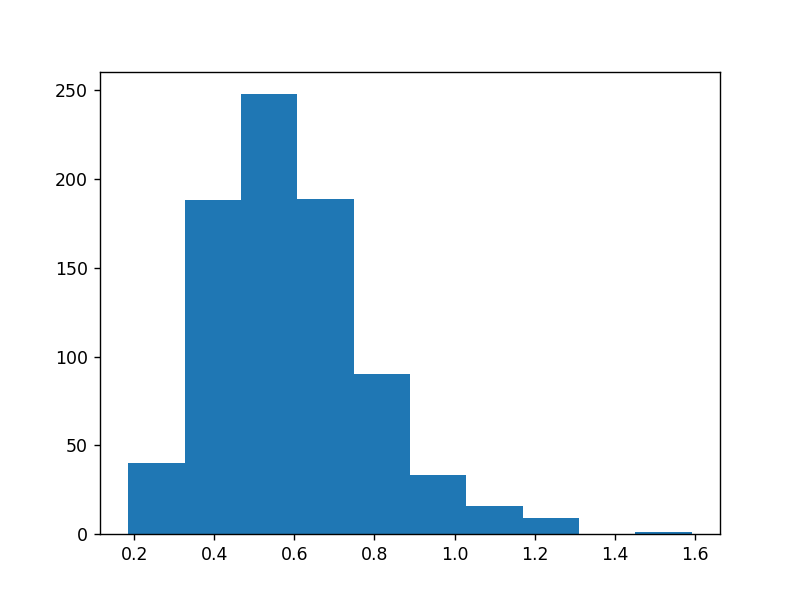

In [36]:
plt.hist(std_dev_rr)
plt.show()